# Mutual Information Neural Estimation
#### Miguel Videla A. <br> Information and Decision Systems Group

Implementation and results replication of the paper [MINE: Mutual Information Neural Estimation](https://arxiv.org/abs/1801.04062).

In [1]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# Kraskov mutual information implementation (JIDT Library)
#!pip install JPype1
import jpype
#!wget http://lizier.me/joseph/software/jidt/download.php?file=infodynamics-dist-1.5.zip
#!unzip -q download.php?file=infodynamics-dist-1.5.zip -d infodynamics
jpype.startJVM(jpype.getDefaultJVMPath(), "-ea", "-Djava.class.path=infodynamics/infodynamics.jar")

C:\Users\Miguel\Anaconda3\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


### 1. MINE implementation

In [3]:
class MINE:  
  def __init__(self, statistical_network, KL_divergence='algo', optimizer='Adam', lr=0.001):
    self.statistical_network = statistical_network
    self.KL_divergence = KL_divergence
    if optimizer == 'Adam':
      self.optimizer = optim.Adam(self.statistical_network.parameters())
    self.moving_average_e_T = 1.0
    self.moving_average_rate = 0.001
     
  def mi_estimation(self, joint_samples, marginal_samples):
    T = self.statistical_network(joint_samples)
    e_T = torch.exp(self.statistical_network(marginal_samples))
    mi_lower_bound = T.mean() - torch.log(e_T.mean())
    return mi_lower_bound, T, e_T
  
  def bias_correction(self, T, e_T):
    ma_e_T = (1 - self.moving_average_rate) * self.moving_average_e_T \
    + self.moving_average_rate * torch.mean(e_T)
    self.moving_average_e_T = ma_e_T
    bias_correction = (torch.mean(T) - (1 / ma_e_T.mean()).detach() * torch.mean(e_T))
    return bias_correction
  
  def train_step(self, joint_samples, marginal_samples):
    mi, T, e_T = self.mi_estimation(batch_joint, batch_marginal)
    loss = -self.bias_correction(T, e_T)
    self.optimizer.zero_grad()
    autograd.backward(loss)
    self.optimizer.step()
    return mi.item()
    
    
class MINE_Dataset(Dataset):
  def __init__(self, joint_samples, marginal_samples):
    self.joint_samples = joint_samples
    self.marginal_samples = marginal_samples

  def __len__(self):
    return self.joint_samples.shape[0]

  def __getitem__(self, index):
    joint_sample = self.joint_samples[index]
    marginal_sample = self.marginal_samples[index]
    return joint_sample, marginal_sample
  
  
class MLP(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(MLP, self).__init__()
    self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = torch.nn.Linear(hidden_dim, output_dim)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

### 2. Comparing MINE to non-parametric estimation

Mutual information estimation between two multivariate Gaussian random variables, $X_a$ and $X_b$, with componentwise correlation, $corr(X_a^i,X_b^j)=δ_{ij}ρ$, where $ρ ∈ (−1, 1)$ and $δ_{ij}$ the Kronecker’s delta. 

In [4]:
def multivariate_gaussian_sampler(dim, corr_factor, n_samples):
  '''
  Generates samples from two gaussian random variables X_a and X_b of 
  dimension dim with Corr(X_a^i, X_b^j) = delta_ij * corr_factor, returning the 
  theoretical mutual information MI(X_a, X_b).
  '''
  joint_mean = np.zeros(2 * dim)
  identity = np.identity(dim)
  joint_cov = np.concatenate([np.concatenate([identity, corr_factor * identity], axis=1),
                              np.concatenate([corr_factor * identity, identity], axis=1)], 
                             axis=0)
  np.fill_diagonal(joint_cov, 1)
  theoretical_mi = -(1/2) * np.log(np.linalg.det(joint_cov))
  X_joint = np.random.multivariate_normal(joint_mean, joint_cov, size=n_samples)
  X_a = X_joint[:, :dim]
  X_b = X_joint[:, dim:]
  return X_joint, X_a, X_b, theoretical_mi

In [5]:
# Kraskov Mutual Information Estimation
dims = [1, 8, 20]
rhos = [-0.99, -0.90, -0.70, -0.50, -0.30, -0.10,
        0.00, 0.10, 0.30, 0.50, 0.70, 0.90, 0.99]

kraskov_mi = [[], [], []]

for i in range(len(dims)):
  for rho in tqdm(rhos):
    # Sampling
    _, X_a, X_b, mi = multivariate_gaussian_sampler(dims[i], rho, 1000)
    Kraskov1ContinuousClass = jpype.JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov1
    kraskov = Kraskov1ContinuousClass()
    kraskov.initialise(X_a.shape[1], X_b.shape[1])
    kraskov.setObservations(X_a.tolist(), X_b.tolist())
    mi = kraskov.computeAverageLocalOfObservations()  
    kraskov_mi[i].append(mi)
kraskov_mi = np.array(kraskov_mi)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.34it/s]


In [6]:
# MINE Mutual Information Estimation
dims = [1, 8, 20]
hidden_layers = [5, 16, 40]
n_epochs = 2500
rhos = [-0.99, -0.90, -0.70, -0.50, -0.30, -0.10,
        0.00, 0.10, 0.30, 0.50, 0.70, 0.90, 0.99]
mine_mi = [[], [], []]
true_mi = [[], [], []]
mine_train_mi = [[], [], []]

for i in range(len(dims)):
  for rho in tqdm(rhos):
    #print('Rho: {}'.format(rho))
    mlp = MLP(dims[i]*2, hidden_layers[i], 1)
    mine = MINE(mlp)
    MIs = []
    for epoch in range(n_epochs):
      epoch_mi = []
      # Sampling
      X_joint, X_a, _, theoretical_mi = multivariate_gaussian_sampler(dims[i], rho, 1000)
      _, _, X_b, _ = multivariate_gaussian_sampler(dims[i], rho, 1000)
      X_marginal = np.hstack((X_a, X_b))
      # Dataset generator
      dataset = MINE_Dataset(X_joint, X_marginal)
      dataloader = DataLoader(dataset, batch_size=250, shuffle=True)
      for j, batch in enumerate(dataloader):
        batch_joint, batch_marginal = batch
        batch_joint = batch_joint.float()
        batch_marginal = batch_marginal.float()
        mi = mine.train_step(batch_joint, batch_marginal)
        epoch_mi.append(mi)
      epoch_mi = np.array(epoch_mi)
      MIs.append(epoch_mi.mean())
    mine_mi[i].append(MIs[-1])
    true_mi[i].append(theoretical_mi)
    mine_train_mi[i].append(MIs)
mine_mi = np.array(mine_mi)
true_mi = np.array(true_mi)
mine_train_mi = np.array(mine_train_mi)

100%|█████████████████████████████████████████████████████████████████████████████████| 13/13 [23:26<00:00, 104.82s/it]


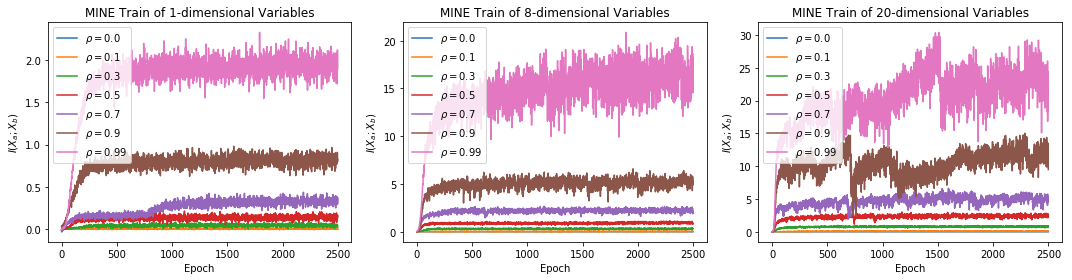

In [7]:
# MINE train curves
plt.figure(figsize=(15, 4))
for i in range(len(dims)):
  plt.subplot(1, 3, i+1)
  for j in range(6, len(rhos)):
    plt.plot(mine_train_mi[i,j,:], label=r'$\rho={}$'.format(rhos[j]))
  plt.xlabel('Epoch')
  plt.ylabel(r'$I(X_a;X_b)$')
  plt.title('MINE Train of {}-dimensional Variables'.format(dims[i]))
  plt.legend()
plt.tight_layout()
plt.savefig('mine_train.png', dpi=300)
plt.show()

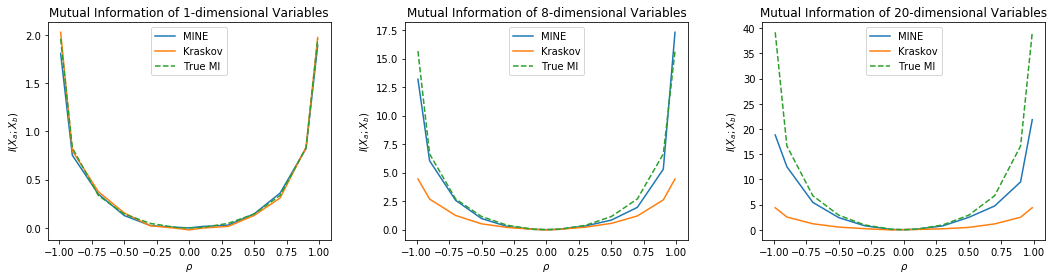

In [12]:
# Mutual Information Estimation Comparison
plt.figure(figsize=(15, 4))
for i in range(len(dims)):
  plt.subplot(1, 3, i+1)
  plt.plot(rhos, mine_mi[i,:], label='MINE')
  plt.plot(rhos, kraskov_mi[i,:], label='Kraskov')
  plt.plot(rhos, true_mi[i,:], '--', label='True MI')
  plt.xlabel(r'$\rho$')
  plt.ylabel(r'$I(X_a;X_b)$')
  plt.title('Mutual Information of {}-dimensional Variables'.format(dims[i]))
  plt.legend()
plt.tight_layout()
plt.savefig('mi_comparison.png', dpi=300)
plt.show()

### 3. Capturing non-linear dependencies

Mutual information estimation by MINE between 2-dimensional random variables $X ∼ \mathcal{U}(−1, 1)$ and $Y = f(X) + σ \odot \epsilon$, where $f(x) ∈ \{x, x^3, sin(x)\}$ and $\epsilon ∼ \mathcal{N} (0, I)$.

In [9]:
dim = 2
n_samples = 1000
n_epochs = 2500
sigmas = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
mi_estimation = []

# Equitability test sampling
def equitability_sampling(dim, sigma, n_samples, i):
  # X Sampling
  X = np.random.uniform(-1, 1, (n_samples, dim))
  # f(X) Sampling
  if i == 0:
    f_X = X
  elif i == 1:
    f_X = X ** 3
  elif i == 2:
    f_X = np.sin(X)
  # Y Sampling
  epsilon = np.random.multivariate_normal(mean=np.zeros(dim), cov=np.eye(dim), size=n_samples)
  Y = f_X + sigma * epsilon
  return X, Y

# Mutual information estimation
for i in range(3):
  mi_fun = []
  for sigma in tqdm(sigmas):
    # MINE initialization
    mlp = MLP(dim * 2, 8, 1)
    mine = MINE(mlp)
    # MINE train
    for epoch in range(n_epochs):
      epoch_mi = []
      # Distributions sampling
      X_1, Y_1 = equitability_sampling(dim, sigma, n_samples, i)
      X_2, Y_2 = equitability_sampling(dim, sigma, n_samples, i)
      joint_samples = np.hstack((X_1, Y_1))
      marginal_samples = np.hstack((X_1, Y_2))
      # Dataset generator
      dataset = MINE_Dataset(joint_samples, marginal_samples)
      dataloader = DataLoader(dataset, batch_size=250, shuffle=True)
      for j, batch in enumerate(dataloader):
        batch_joint, batch_marginal = batch
        batch_joint = batch_joint.float()
        batch_marginal = batch_marginal.float()
        mi = mine.train_step(batch_joint, batch_marginal)
        epoch_mi.append(mi)
    epoch_mi = np.array(epoch_mi)
    # Last epoch MI mean
    mi_sigma = epoch_mi.mean()
    mi_fun.append(mi_sigma)
  mi_estimation.append(mi_fun)
mi_estimation = np.array(mi_estimation)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [09:02<00:00, 53.27s/it]


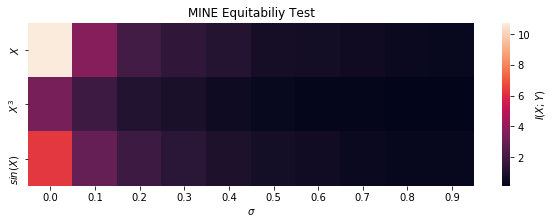

In [10]:
# MINE equitability test results
plt.figure(figsize=(10,3))
sns.heatmap(mi_estimation, 
            xticklabels=sigmas, 
            yticklabels=[r'$X$', r'$X^3$', r'$sin(X)$'],
            cbar_kws={'label': r'$I(X;Y)$'})
plt.xlabel(r'$\sigma$')
plt.title('MINE Equitabiliy Test')
plt.savefig('equitability.png', dpi=300)
plt.show()